# 1.导入所需要的包

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import pickle
import gc
import xgboost as xgb
import re
from sklearn.model_selection import train_test_split

# 2.数据分析

In [2]:
train = pd.read_csv(r'C:/Users/CHICHI/Desktop/文本正则化/input\\en_train.csv')
train.shape
train.head()

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


In [3]:
len(train["class"].unique())

16

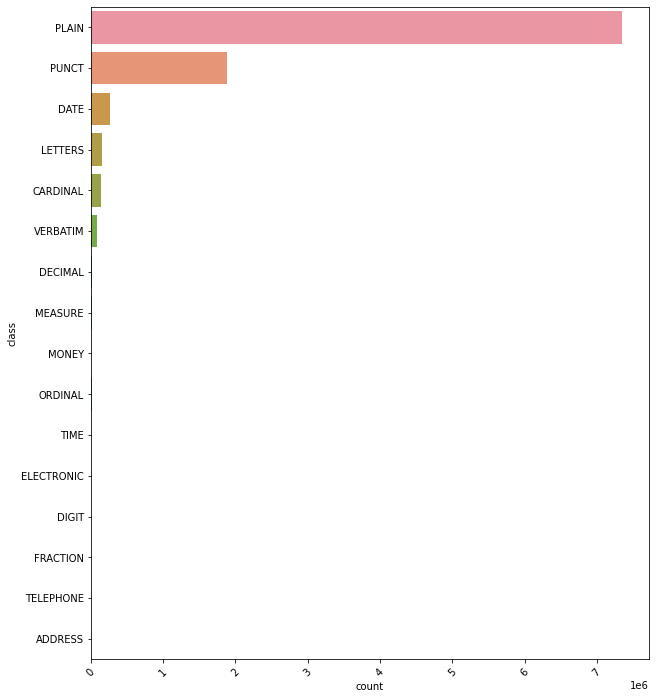

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,12))
#sns.set_style("whitegrid")
count_classes_fig = sns.countplot(y="class", data=train, ax=ax)
for item in count_classes_fig.get_xticklabels():
    item.set_rotation(45)

In [5]:
train.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152795
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353693
PUNCT         1880507
TELEPHONE        4024
TIME             1465
VERBATIM        78108
Name: class, dtype: int64

In [6]:
num_train_sentences = len(train.sentence_id.unique())
num_train_sentences

748066

In [7]:
train_sentences = train.groupby("sentence_id")["sentence_id"].count()
train_sentences.describe()

count    748066.000000
mean         13.258778
std           6.071624
min           2.000000
25%           8.000000
50%          13.000000
75%          18.000000
max         256.000000
Name: sentence_id, dtype: float64

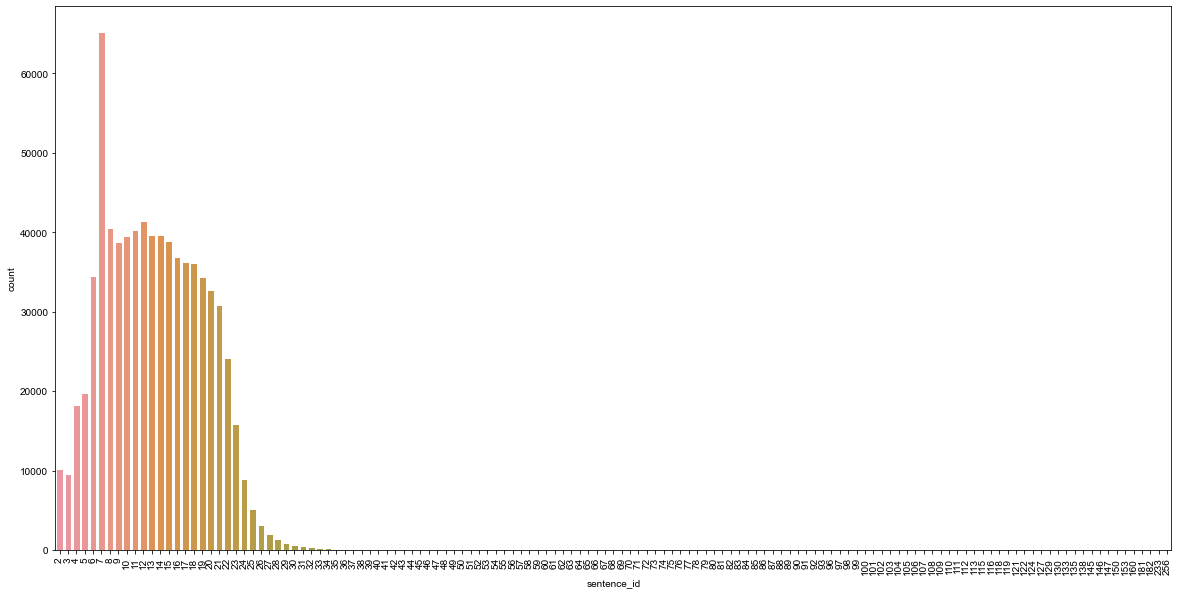

In [8]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.set_style("whitegrid")
count_length_fig = sns.countplot(train_sentences, ax=ax)
for item in count_length_fig.get_xticklabels():
    item.set_rotation(90)

In [9]:
max_id = train_sentences[train_sentences == train_sentences.max()].index.values
max_id

array([520453], dtype=int64)

In [10]:
long_example = train[train.sentence_id==max_id[0]].before.values.tolist()
long_example= ' '.join(long_example)
long_example

"R . Naroll , V.L. Bullough & F. Naroll , Military Deterrence in History : A Pilot Cross Historical Survey , SUNY Press , 1974 H . Temporini & W. Haase , Aufstieg und Niedergang der romischen Welt : Geschichte und Kultur Roms im spiegel der neueren Forschung , Walter de GruyterE . Yarshater , The Cambridge History of Iran , Cambridge University Press , 1983 R . Syme & A.R. Birley , Anatolica : studies in Strabo , Oxford University Press , 1995 W.G. Sayles , Ancient Coin Collecting IV : Roman Provincial Coins ( Google eBook ) , F +W Media , Inc , 1998 P.M. Swan , The Augustan Succession : An Historical Commentary on Cassius Dio's Roman History , Books 55 - 56 ( 9 B.C. - A.D. 14 ) ( Google eBook ) , Oxford University Press , 2004 R.G. Hovannisian , The Armenian People from Ancient to Modern Times , Volume 1 : The Dynastic Periods : From Antiquity to the Fourteenth Century , Palgrave Macmillan , 2004 V.M. Kurkjian , A History of Armenia , Indo European Publishing , 2008 M.A. Ehrlich , Enc

# 3.数据建模分类

In [13]:
max_num_features = 10
pad_size = 1
boundary_letter = -1
space_letter = 0
# max_data_size = 320000
self_classes = ["PLAIN", "PUNCT"]
param = {'objective': 'multi:softmax',
             'eta': '0.3',
             'max_depth': 10,
             'silent': 1,
             'nthread': -1,
             # 'num_class':num_class,
             'num_class': 2,
             'eval_metric': 'merror'}

In [23]:
out_path = r'C:/Users/CHICHI/Desktop/文本正则化/output'
df = pd.read_csv(r'C:/Users/CHICHI/Desktop/文本正则化/input/en_train.csv', encoding='utf8')
df_test = pd.read_csv(r'C:/Users/CHICHI/Desktop/文本正则化/input/en_test_2.csv', encoding='utf8')

In [24]:
y_data =  pd.factorize(df['class'])
labels = y_data[1]

In [25]:
x_test = []    
for x in df_test['before'].values:
    x_row = np.ones(max_num_features, dtype=int) * space_letter
    for xi, i in zip(list(str(x)), np.arange(max_num_features)):
        x_row[i] = ord(xi)
    x_test.append(x_row)

In [26]:
def context_window_transform(data, pad_size):
    pre = np.zeros(max_num_features)
    pre = [pre for x in np.arange(pad_size)]
    data = pre + data + pre
    neo_data = []
    for i in np.arange(len(data) - pad_size * 2):
        row = []
        for x in data[i : i + pad_size * 2 + 1]:
            row.append([boundary_letter])
            row.append(x)
        row.append([boundary_letter])
        neo_data.append([int(x) for y in row for x in y])
    return neo_data

In [38]:
x_test = np.array(context_window_transform(x_test, pad_size))
x_test = np.array(x_test)
# print(x_test)

[list([-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1])
 list([-1, -1, -1, -1]) list([-1, -1, -1, -1]) ... list([-1, -1, -1, -1])
 list([-1, -1, -1, -1])
 list([-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1])]


In [28]:
print('Total number of test samples:', len(x_test))

Total number of test samples: 956046


In [19]:
print(labels)

40

In [29]:
dtest = xgb.DMatrix(x_test)

In [34]:
model = xgb.Booster({'nthread':-1})
model.load_model(os.path.join(out_path, 'xgb_model'))

In [ ]:
idlist=[]

In [ ]:
idlist=[str(""+str(e[0])+"_"+str(e[1])) for e in list(zip(sentence_id,token_id))]

In [35]:
pred_test = model.predict(dtest)
# pred_test = [labels[int(x)] for x in pred_test]

In [36]:
x_test = [ [ chr(x) for x in y[2 + max_num_features: 2 + max_num_features * 2]] for y in x_test]
x_test = [''.join(x) for x in x_test]
x_test = [re.sub('a+$', '', x) for x in x_test]
gc.collect()

0

In [37]:
df_pred_test = pd.DataFrame(columns=['data', 'predict'])
df_pred_test['data'] = x_test
df_pred_test['predict'] = pred_test
df_pred_test.to_csv(os.path.join(out_path, 'pred_test_2.csv'), encoding='utf8')